# Comparing Jaccard and word2vec similarities

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

import numpy as np
import scipy.spatial as sp
import tensorflow as tf

import similarities.loading as sl
import resources.dataset as rd
import resources.queries as rq

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.rcParams["figure.figsize"] = (4,4)
mpl.rcParams['figure.dpi']= 150
mpl.rcParams['figure.titlesize']= 'xx-large'
mpl.rcParams['font.size']= 6
mpl.rcParams['image.cmap'] = 'jet'
cmap = cm.get_cmap('jet')
cmap.set_bad('w') # Print bads as white

sess = tf.Session() # tensorflow

### [Aminer Citation Network Datasets - v1 and v9](https://aminer.org/citation)



In [3]:
#data_path = "resources/aminer/v1"
data_path = "resources/aminer/v9"

### Select related documents or not

In [4]:
related_docs = True

### Loading similarity matrices

Each matrix has similarity values between documents in a sample of scientific articles (Aminer), with one of the following measures.

 - word2vec. Mean of similarity of the bag of words in each document.
 - Jaccard. Using bag of words.
 - Jaccard disimilarity. It is properly a distance ($1 - J$)
 - Dice. It is computed from Jaccard, given that it is equivalent to $\dfrac{2\dot J}{1 + J}$ 

In [5]:
# Load sparse matrix with jaccard similarities.
matrix_tmp = sl.load_matrix_jaccard_sim(data_path, related_docs=related_docs)

n = matrix_tmp.shape[0]

matrix_jaccard = tf.constant(matrix_tmp, name='matrix_jaccard')

# dice
matrix_dice = tf.constant(np.divide(np.multiply(2,matrix_tmp), np.add(matrix_tmp, 1)), name='matrix_dice')

# Jaccard disimilarity
matrix_jaccard_dis =  tf.constant(np.subtract(1, matrix_tmp), name='matrix_jaccard_dis')

del matrix_tmp

# Load sparse matrix with word2vec similarities.
matrix_tmp = sl.load_matrix_word2vec_sim(data_path, related_docs=related_docs)

matrix_word2vec = tf.constant(matrix_tmp, name='matrix_word2vec')

del matrix_tmp

pltmask =  np.tri(n, k=-1) # Mask to plot upper triangular matrix.   

# Load document ids in the Same order than the matrices
indexdocs = rd.get_sample_ids(data_path)

print("\nMatrices.")
print(matrix_jaccard)
print(matrix_jaccard_dis)
print(matrix_dice)
print(matrix_word2vec)

Loading measures from file ...
 - 502503 measures loaded from resources/aminer/v9/measures-100-10-0-related.bin 
Sample size: 1002 documents
 - Content from resources/aminer/v9/index-data-sample-100-10-0-related.bin
Loading measures from file ...
 - 502503 measures loaded from resources/aminer/v9/measures-100-10-0-related.bin 
Sample size: 1002 documents
 - Content from resources/aminer/v9/index-data-sample-100-10-0-related.bin



Matrices.
Tensor("matrix_jaccard:0", shape=(1002, 1002), dtype=float64)
Tensor("matrix_jaccard_dis:0", shape=(1002, 1002), dtype=float64)
Tensor("matrix_dice:0", shape=(1002, 1002), dtype=float64)
Tensor("matrix_word2vec:0", shape=(1002, 1002), dtype=float64)


Sample size: 1002 documents
 - Content from resources/aminer/v9/index-data-sample-100-10-0-related.bin


## SVD with TensorFlow

In [6]:
M = tf.Variable(tf.zeros((n,n),  dtype=tf.float64), dtype=tf.float64, name='M') 
s, u, v = tf.svd(M) #SVD

# ns = n
ns = 1 # one singular value

# UDV' matrix reconstruction with ns singular values
M_ = tf.matmul(u[:,:ns], tf.matmul(tf.diag(s[:ns]), v[:,:ns], adjoint_b=True)) 
# M_ = tf.matmul(u[:,:ns], v[:,:ns], adjoint_b=True) # UV'

sess.run(tf.global_variables_initializer())  

print("\nM_ is the reconstruction of the matrix M with %d singular value(s)." % (ns))


M_ is the reconstruction of the matrix M with 1 singular value(s).


### Reconstruction of matrices with singular values

In [7]:
op = M.assign(matrix_jaccard)
sess.run(op)
jaccard_approximation = sess.run(M_) # Reconstruction of the matrix M
jaccard_singular_values = sess.run(s) # Singular values  

op = M.assign(matrix_jaccard_dis)
sess.run(op)
jaccarddis_approximation = sess.run(M_)
jaccarddis_singular_values = sess.run(s)

op = M.assign(matrix_dice)
sess.run(op)
dice_approximation = sess.run(M_)
dice_singular_values = sess.run(s)

op = M.assign(matrix_word2vec)
sess.run(op)
word2vec_approximation = sess.run(M_)
word2vec_singular_values = sess.run(s)

print("Matrix reconstructions using %d singular value(s)" % (ns))

Matrix reconstructions using 1 singular value(s)


#### Largest singular values for each matrix

In [8]:
print("SVD: Largest singular values:\n \
        \nJaccard sim. s0 = %f \nJaccard dis. s0 = %f \nDice sim. s0 = %f \
        \nwod2vec sim. s0 = %f" % (jaccard_singular_values[0], jaccarddis_singular_values[0], 
      dice_singular_values[0], word2vec_singular_values[0]))

SVD: Largest singular values:
         
Jaccard sim. s0 = 9.801361 
Jaccard dis. s0 = 995.171237 
Dice sim. s0 = 16.597588         
wod2vec sim. s0 = 95.541111


## Plotts

### Singular values

In the following graph $s_0$ is not plotted because it is too large for wod2vec similarities and jaccard disimilarities. 

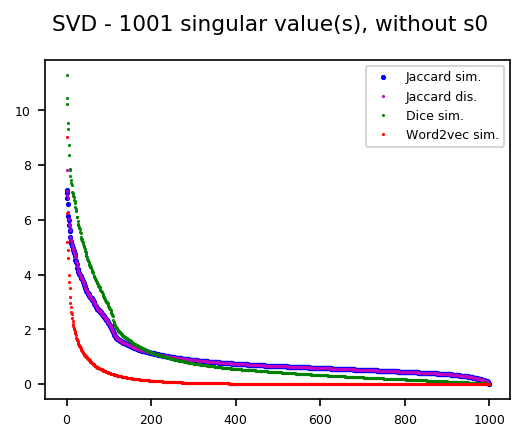

In [9]:
fig = plt.figure(figsize=(4, 3))
fig.suptitle("SVD - %d singular value(s), without s0" % (n - 1))

# Plotting singular values. s0 is too large for word2vec
ax1 = plt.subplot(1, 1, 1)
ax1.plot(jaccard_singular_values[1:], 'b.', mew=1.0, ms=3.0, label="Jaccard sim.")
ax1.plot(jaccarddis_singular_values[1:], 'm.', mew=1.0, ms=1.0, label="Jaccard dis.")
ax1.plot(dice_singular_values[1:], 'g.', mew=1.0, ms=1.0, label="Dice sim.")
ax1.plot(word2vec_singular_values[1:], 'r.', mew=1.0, ms=1.0, label="Word2vec sim.")

plt.legend()
plt.show()

### Comparing reconstructed matrices with their originals 

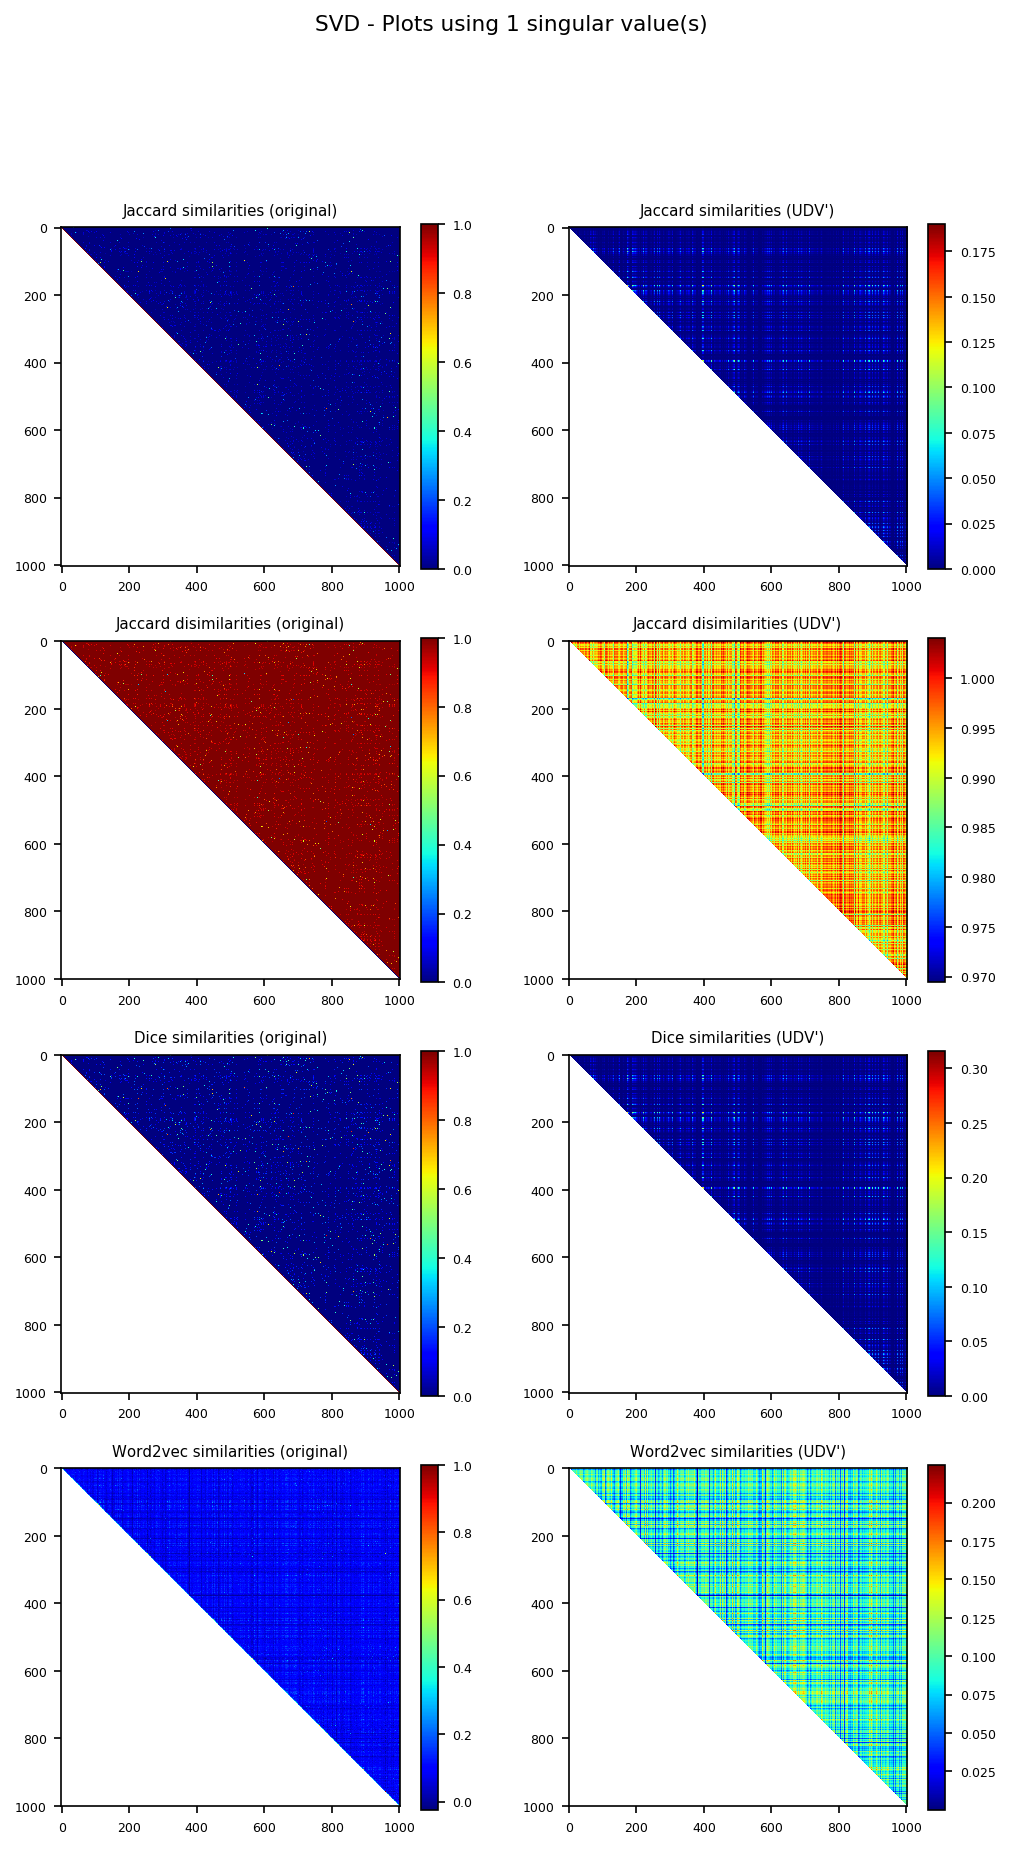

In [10]:
fig = plt.figure(figsize=(8,14))
fig.suptitle("SVD - Plots using %d singular value(s)" % (ns))

ax_jaccard = plt.subplot(4, 2, 1)
ax_jaccard.set_title("Jaccard similarities (original)")
im_jaccard = ax_jaccard.imshow(np.ma.array(sess.run(matrix_jaccard), mask=pltmask))
plt.colorbar(im_jaccard)
# Reconstructed matrix using the largest singular value.
ax_jaccard_ = plt.subplot(4, 2, 2)
ax_jaccard_.set_title("Jaccard similarities (UDV')")
im_jaccard_ = ax_jaccard_.imshow(np.ma.array(jaccard_approximation, mask=pltmask))

plt.colorbar(im_jaccard_)

ax_jaccard_dis = plt.subplot(4, 2, 3)
ax_jaccard_dis.set_title("Jaccard disimilarities (original)")
im_jaccarddis = ax_jaccard_dis.imshow(np.ma.array(sess.run(matrix_jaccard_dis), mask=pltmask))
plt.colorbar(im_jaccarddis)
# Reconstructed matrix using the largest singular value.
ax_jaccard_dis_ = plt.subplot(4, 2, 4)
ax_jaccard_dis_.set_title("Jaccard disimilarities (UDV')")
im_jaccarddis_ = ax_jaccard_dis_.imshow(np.ma.array(jaccarddis_approximation, mask=pltmask))
plt.colorbar(im_jaccarddis_)

ax_dice = plt.subplot(4, 2, 5)
ax_dice.set_title("Dice similarities (original)")
im_dice = ax_dice.imshow(np.ma.array(sess.run(matrix_dice), mask=pltmask))
plt.colorbar(im_dice)
# Reconstructed matrix using the largest singular value.
ax_dice_ = plt.subplot(4, 2, 6)
ax_dice_.set_title("Dice similarities (UDV')")
im_dice_ = ax_dice_.imshow(np.ma.array(dice_approximation, mask=pltmask))
plt.colorbar(im_dice_)

ax_word2vec = plt.subplot(4, 2, 7)
ax_word2vec.set_title("Word2vec similarities (original)")
im_word2vec = ax_word2vec.imshow(np.ma.array(sess.run(matrix_word2vec), mask=pltmask))
plt.colorbar(im_word2vec)
# Reconstructed matrix using the largest singular value.
ax_word2vec_ = plt.subplot(4, 2, 8)
ax_word2vec_.set_title("Word2vec similarities (UDV')")
im_word2vec_ = ax_word2vec_.imshow(np.ma.array(word2vec_approximation, mask=pltmask))
plt.colorbar(im_word2vec_)

plt.show()

### Ordering matrices for better visualization 

From the matrix approximations with SVD is calculated the mean for each column. Later, the means are used to order the matrices. 

In [11]:
# Means of jaccard similarities using the reconstructed matrix 
jaccard_similarity_mean = tf.reduce_mean(jaccard_approximation, 1)
# Ordered indices by mean of similarities in the approximation
jaccard_indices = sess.run(jaccard_similarity_mean).argsort()[::-1]

# Means of word2vec similarities using the reconstructed matrix 
word2vec_similarity_mean = tf.reduce_mean(word2vec_approximation, 1)
# Ordered indices by mean of similarities in the approximation
word2vec_indices = sess.run(word2vec_similarity_mean).argsort()[::-1]

#### Jaccard matrix ordered by means of word2vec similarities

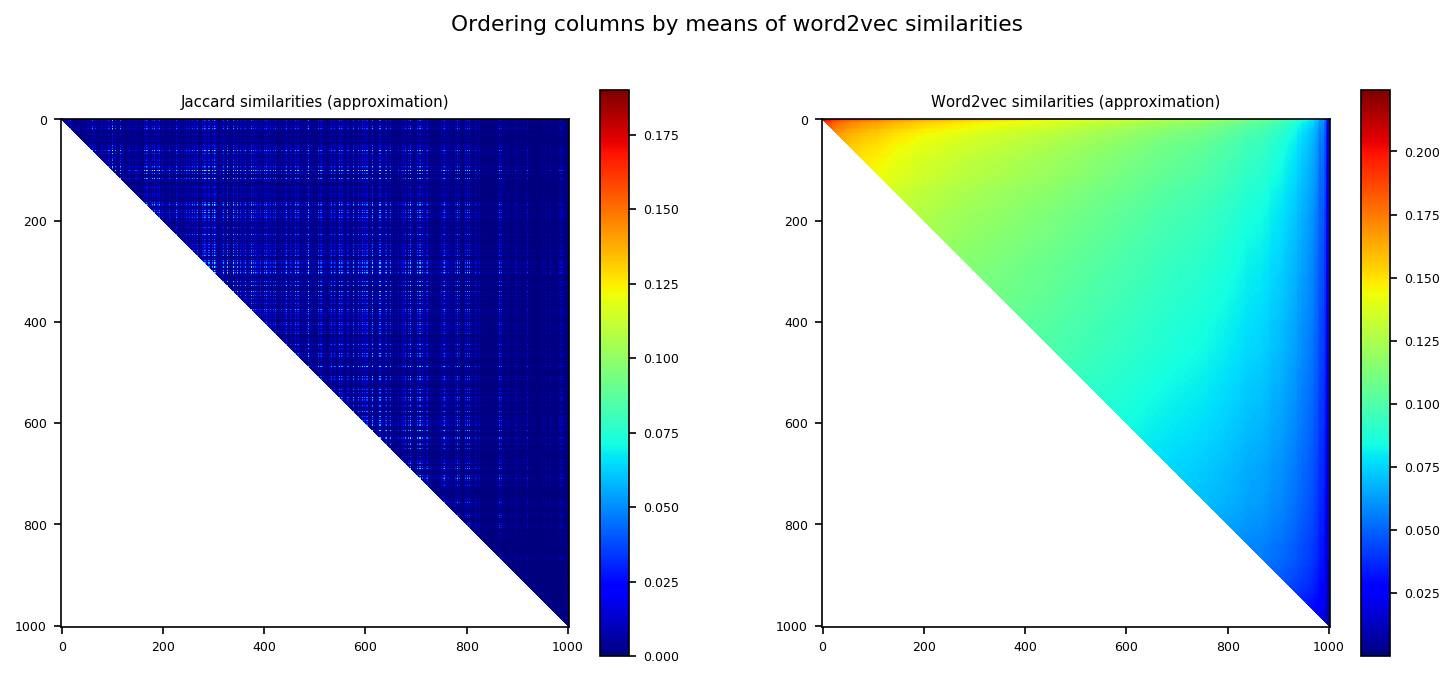

In [12]:
fig = plt.figure(figsize=(12,5))
fig.suptitle("Ordering columns by means of word2vec similarities")

ax_jaccard = plt.subplot(1, 2, 1)
ax_jaccard.set_title("Jaccard similarities (approximation)")
im_jaccard_arranged = ax_jaccard.imshow(np.ma.array(
    jaccard_approximation[:,word2vec_indices][word2vec_indices,:], mask=pltmask))
plt.colorbar(im_jaccard_arranged)

ax_word2vec = plt.subplot(1, 2, 2)
ax_word2vec.set_title("Word2vec similarities (approximation)")
im_word2vec_arranged = ax_word2vec.imshow(np.ma.array(
    word2vec_approximation[:,word2vec_indices][word2vec_indices,:], mask=pltmask))
plt.colorbar(im_word2vec_arranged)

plt.show()

## Matching cases where Jaccard sim. is equal to zero

A mask is obtained from jaccard similarities, given $a_{ij} \in A$ with A being the jaccard similarity matrix, then the matrix K is the mask.

\begin{equation}
  k_{ij}=\left\{
  \begin{array}{@{}ll@{}}
    1, & \text{if}\ a_{ij}=0 \\
    0, & \text{otherwise}
  \end{array}\right.
\end{equation} 

Each jaccard similarity equal to zero means that those documents don't have word correspondecy.

### Example of the mask

In [13]:
# Mask
jaccard_mask = sess.run(tf.where( tf.equal(matrix_jaccard, 0.0), 
                                 tf.ones(matrix_jaccard.get_shape()), tf.zeros(matrix_jaccard.get_shape())))

jaccard_mask_ordered = jaccard_mask[:,word2vec_indices][word2vec_indices,:]

with sess.as_default():
    print("Jaccard matrix\n", matrix_jaccard[:3,:3].eval())
    print("\nJaccard mask\n", jaccard_mask[:3,:3])

Jaccard matrix
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Jaccard mask
 [[0. 1. 1.]
 [1. 0. 1.]
 [1. 1. 0.]]


### Example of the mask over word2vec

The mask is applied over word2vec by multiplying each element $a_{ij}k_{ij}$ (it is not a matrix multiplication).

In [14]:
# Mask over word2vec
jaccardmask_word2vecapprox = sess.run(tf.convert_to_tensor(jaccard_mask)*word2vec_approximation)
jaccardmask_word2vecapprox_ordered = jaccardmask_word2vecapprox[:,word2vec_indices][word2vec_indices,:]

with sess.as_default():
    # The resulting word2vec matrix keeps only values of similitaties 
    # where jaccard has a similarity of zero
    print("Small example with the mask.")
    print("\nword2vec (approx.)\n", word2vec_approximation[:3,:3])
    print("\nMaskered word2vec\n", jaccardmask_word2vecapprox[:3,:3])

Small example with the mask.

word2vec (approx.)
 [[0.16695315 0.13945989 0.13757783]
 [0.13945989 0.11649413 0.114922  ]
 [0.13757783 0.114922   0.11337108]]

Maskered word2vec
 [[0.         0.1394599  0.13757783]
 [0.1394599  0.         0.11492199]
 [0.13757783 0.11492199 0.        ]]


### Visualizing word2vec with the mask

This mask is only used to illustrate that similar documents don't necessarily have co-occurrence of words.

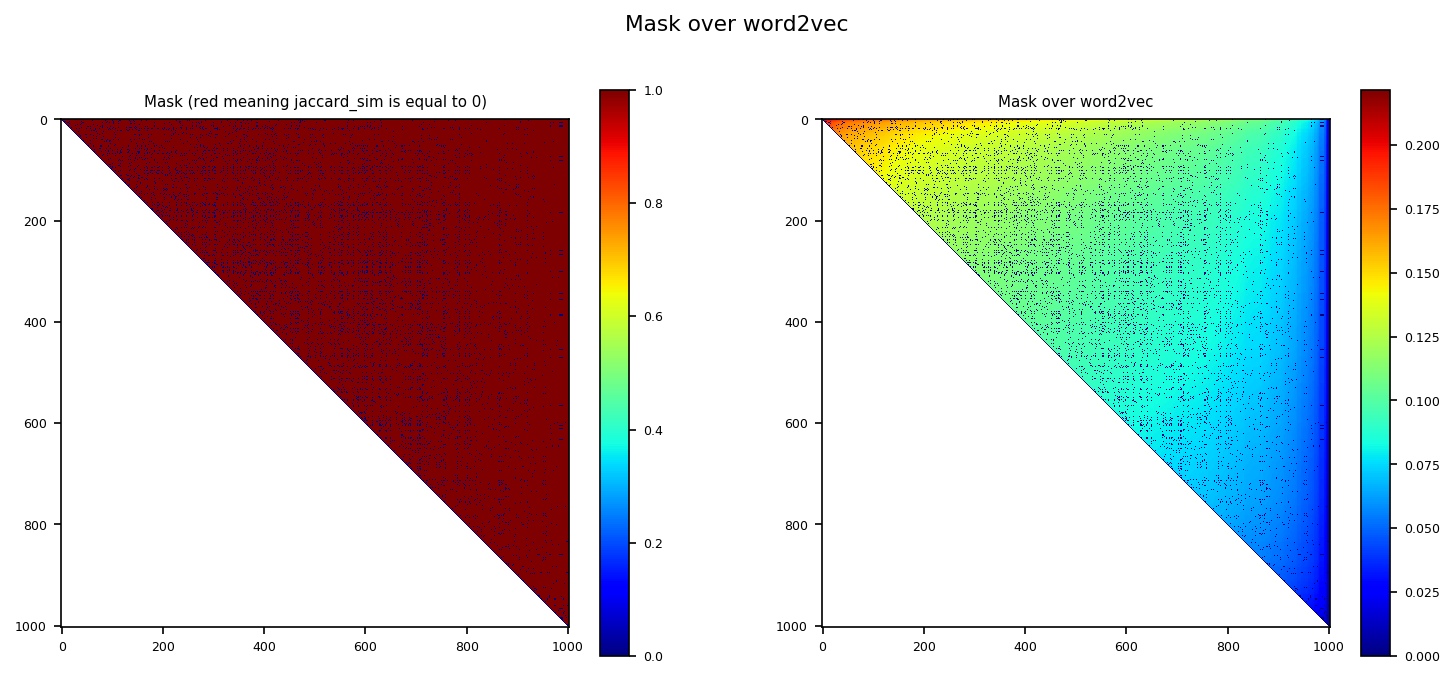

In [15]:
fig = plt.figure(figsize=(12,5))
fig.suptitle("Mask over word2vec")

ax_mask = plt.subplot(1, 2, 1)
ax_mask.set_title("Mask (red meaning jaccard_sim is equal to 0)")
im_mask = ax_mask.imshow(
                np.ma.array(
                    jaccard_mask_ordered, 
                    mask=pltmask
                )
            )
plt.colorbar(im_mask)

ax_jm_wa = plt.subplot(1, 2, 2)
ax_jm_wa.set_title("Mask over word2vec")
im_jm_wa = ax_jm_wa.imshow(
                np.ma.array(
                    jaccardmask_word2vecapprox_ordered, 
                    mask=pltmask
                )
            )
plt.colorbar(im_jm_wa)
plt.show()

In the matrix to the right, zero values (darker zones) represent jaccard similarities greater than zero. Meaning that the colored zones correspond to documents that have semantic similarity without correspondence between their words.

### Zoom over documents more similar to the rest (Upper-Left corner)

Selecting submatrix from the upper-left corner.

In [16]:
size_submatrix = int(np.ceil(n/5))
subpltmask = pltmask[:size_submatrix,:size_submatrix]

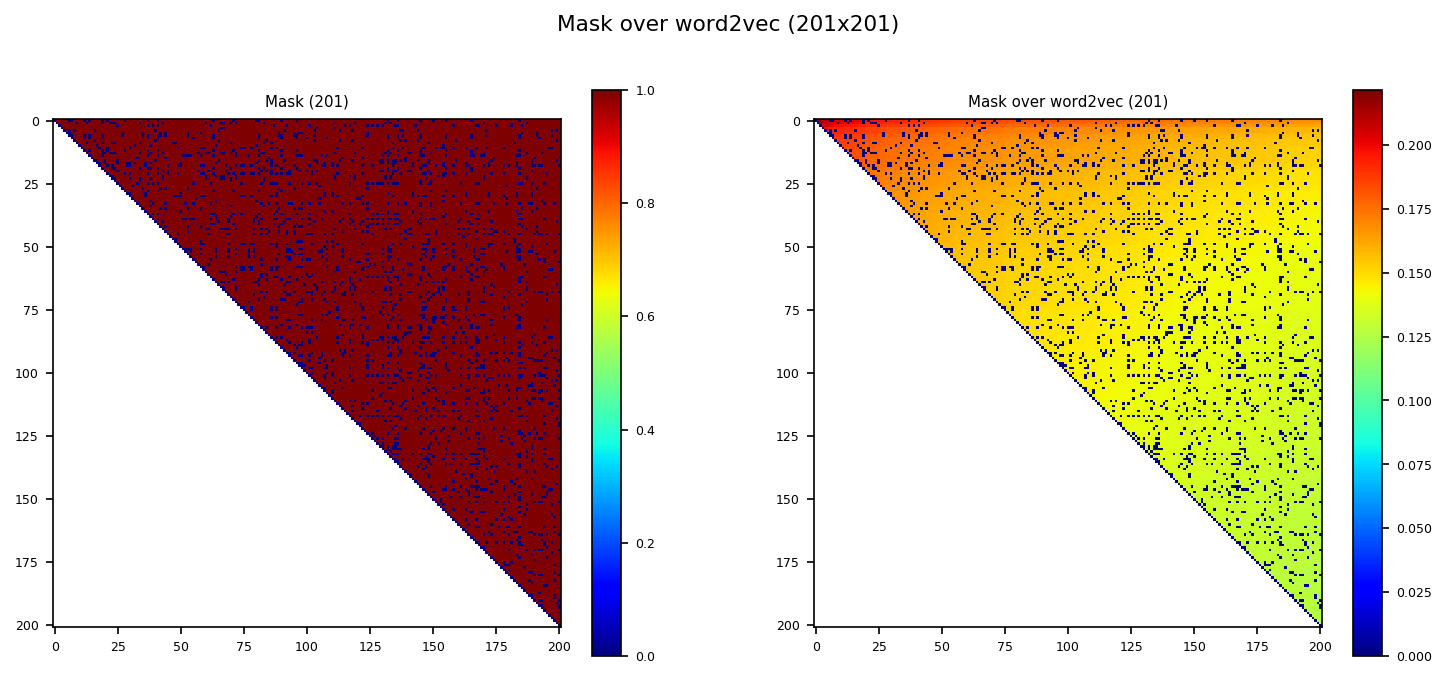

In [17]:
fig = plt.figure(figsize=(12,5))
fig.suptitle("Mask over word2vec (%dx%d)" % (size_submatrix, size_submatrix))

ax_mask_seg = plt.subplot(1, 2, 1)
ax_mask_seg.set_title("Mask (%d)" % size_submatrix )
im_mask_seg = ax_mask_seg.imshow(
                np.ma.array(
                    jaccard_mask_ordered[:size_submatrix,:size_submatrix], 
                    mask=subpltmask
                )
            )
plt.colorbar(im_mask_seg)

ax_jm_wa_seg = plt.subplot(1, 2, 2)
ax_jm_wa_seg.set_title("Mask over word2vec (%d)" % size_submatrix )
im_jm_wa_seg = ax_jm_wa_seg.imshow(
                np.ma.array(
                    jaccardmask_word2vecapprox_ordered[:size_submatrix,:size_submatrix], 
                    mask=subpltmask
                )
            )
plt.colorbar(im_jm_wa_seg)

plt.show()

Defining functions to get the frequency of zeros and ones in the mask.

In [18]:
def freq_zero_jaccard_sim_triu(JM):
    N_JM_i, N_JM_j = JM.shape
    zero_sim = 0
    gt_zero = 0
    total_values = 0
    for i in range(0, N_JM_i):
        j = i+1
        while j < N_JM_j:
            total_values += 1
            if JM[i,j] == 1:
                zero_sim += 1
            else:
                gt_zero += 1
            j += 1
    return zero_sim/total_values, gt_zero/total_values

def freq_zero_jaccard_sim_full(JM):
    N_JM_i, N_JM_j = JM.shape
    zero_sim = 0
    gt_zero = 0
    total_values = 0
    for i in range(0, N_JM_i):
        j = 0
        while j < N_JM_j:
            total_values += 1
            if JM[i,j] == 1:
                zero_sim += 1
            else:
                gt_zero += 1
            j += 1
    return zero_sim/total_values, gt_zero/total_values

### Frequency of jaccard similarities greater than zero

Visualizing masked submatrices with frequency of jaccard similarities greater than zero.

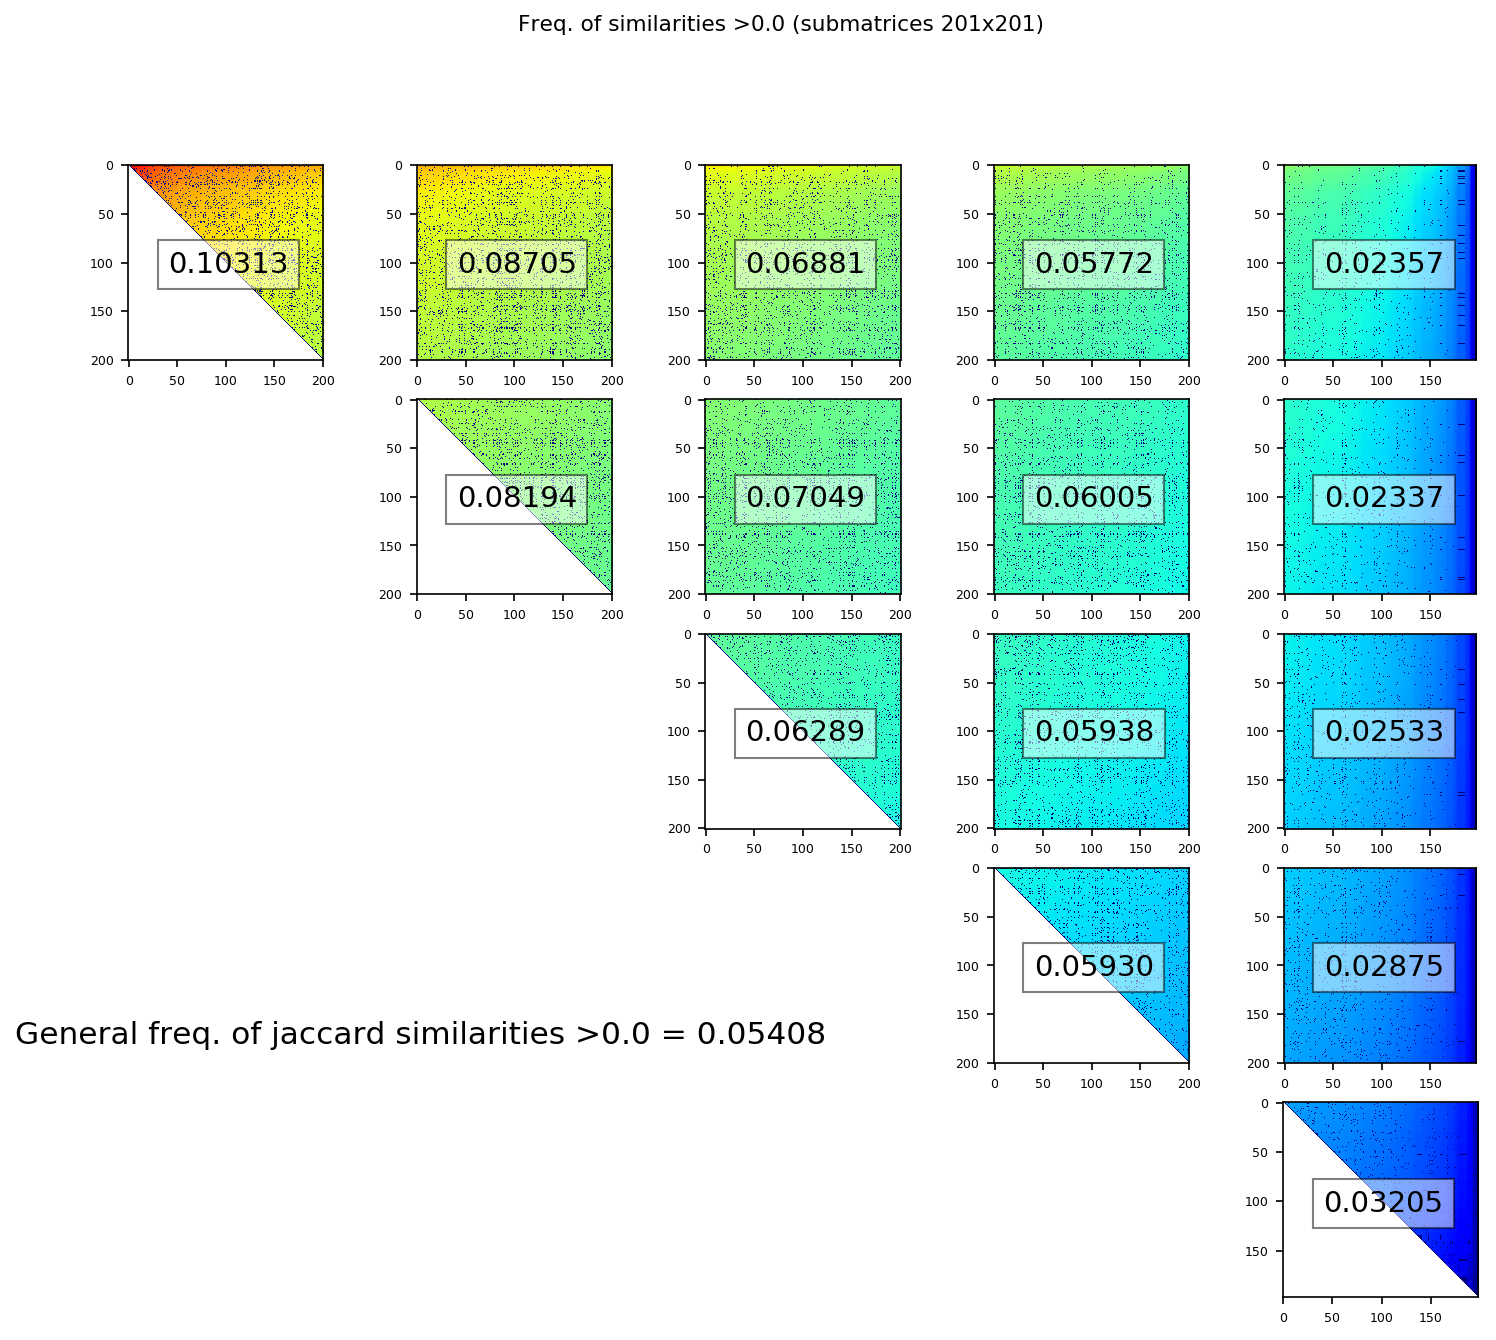

In [19]:
fig = plt.figure(figsize=(12,10))

n_subms = int(np.ceil(n/size_submatrix).tolist())
center_size_submatrix = size_submatrix/2
vmax=jaccardmask_word2vecapprox_ordered.max()

zero_sim_freq_full, gt_zero_sim_freq_full = freq_zero_jaccard_sim_triu(jaccard_mask_ordered)

fig.suptitle("Freq. of similarities >0.0 (submatrices %dx%d)" % (size_submatrix, size_submatrix))

for i_subimage in range(0, n_subms):
    m_istart = i_subimage * size_submatrix
    m_iend = (i_subimage + 1) * size_submatrix
    j_subimage = i_subimage
    while j_subimage < n_subms:   
        m_jstart = j_subimage * size_submatrix
        m_jend = (j_subimage + 1) * size_submatrix
        
        submatrix_tmp = jaccardmask_word2vecapprox_ordered[m_istart:m_iend,m_jstart:m_jend]
        submask_tmp = jaccard_mask_ordered[m_istart:m_iend, m_jstart:m_jend]
        zero_sim_freq, gt_zero_sim_freq = freq_zero_jaccard_sim_triu(submask_tmp) if i_subimage == j_subimage else freq_zero_jaccard_sim_full(submask_tmp) 
        
        plt.subplot(n_subms, n_subms, j_subimage + (i_subimage*n_subms) + 1)     
        plt.text(center_size_submatrix - 60, 
                        center_size_submatrix + 10, 
                        '%.5f' % (gt_zero_sim_freq), 
                        fontsize=14, 
                        color='black',
                        bbox={'facecolor':'white', 'alpha':0.5, 'pad':5}
                   )
        
        im = plt.imshow(
                    np.ma.array(
                        submatrix_tmp, 
                        mask = subpltmask[:submatrix_tmp.shape[0],:submatrix_tmp.shape[0]] if i_subimage == j_subimage else None
                    ),
                    vmin=0.0, vmax=vmax
                )
        j_subimage += 1 

fig.text(0.3, 0.3, 'General freq. of jaccard similarities >0.0 = %.5f' % gt_zero_sim_freq_full, ha='center', va='center', size=15)

plt.show()

## Example of documents

Loading list of documents.

In [20]:
# Ordering documents
indexdocs_ordered_word2vec = np.array(indexdocs)[word2vec_indices]
# Index 
ix_data = rq.cur_indexed_docs(data_path)

# Function to tokenize content
def bag_of_words_from_content(content):
    return " ".join(sorted(list(set([c.text for c in rd.analizer(content)]))))

### Content for n_documents

In [21]:
n_documents = 50

#### Documents to the left of the matrices

In [22]:
print("First %d documents in the matrix\n" % n_documents)
# print(indexdocs_ordered_word2vec[:n_documents])
for idoc in indexdocs_ordered_word2vec[:n_documents]:
    result = rq.find_indexdoc(ix_data, idoc)
    for r in result:
        print(r['indexdoc'], "\t", bag_of_words_from_content(r['content']))

First 50 documents in the matrix

index555036bc7cea80f95414efbe 	 algorithms data functional means
index5736966b6e3b12023e57804a 	 computational engineering technology
index573696516e3b12023e55de6e 	 asymptotically classification discriminant functions optimal pattern
index573696b56e3b12023e5b776f 	 metadata usage
index5736966c6e3b12023e579366 	 complexity matrix multiplication parallel
index573695b46e3b12023e4d1eb5 	 circuits logic quantum synthesis
index58d82fd2d649053542fd7962 	 complexity data description logic ontologies
index57d063bdac4436735428f711 	 core data multidimensional out prefetching spatial visualization
index573695646e3b12023e48a46c 	 matrix multiplication optimization small techniques
index573696616e3b12023e56dd11 	 algebraic applications computational geometry its
index573696656e3b12023e57227d 	 humans interfaces spatiality tangible user
index573695c06e3b12023e4dbac5 	 feedback linear quantized stabilization systems
index573696716e3b12023e57e09a 	 algorithms data me

#### Documents to the rigth of the matrices

In [23]:
print("\n\nLast %d documents in the matrix\n" % n_documents)
# print(indexdocs_ordered_word2vec[-n_documents:])
for idoc in indexdocs_ordered_word2vec[-n_documents:]:
    result = rq.find_indexdoc(ix_data, idoc)
    for r in result:
        print(r['indexdoc'], "\t", bag_of_words_from_content(r['content']))
 



Last 50 documents in the matrix

index555036f57cea80f95416a762 	 bitcoin ecosystem
index573695b36e3b12023e4d10a5 	 ecosystem spatialhadoop
index573695ce6e3b12023e4e71d4 	 fuzzy hyperpath intuitionistic network shortest
index573697aa6e3b12023e68da8f 	 bagging class decision one trees
index5736968f6e3b12023e59a111 	 british computing early forgotten man max newman
index555036c07cea80f954150fac 	 chain competition cournot managing supply uncertainty under
index573696ea6e3b12023e5e8bc3 	 ap cs goes oo
index5736970d6e3b12023e6068ce 	 2006 experiment genomics report trec
index573696266e3b12023e536720 	 compagnie et informatique suite1 économie éditorial
index555036b67cea80f95414b6ac 	 editorial
index573698806e3b12023e740245 	 map mozart
index573696206e3b12023e53185a 	 2012 awards cis ieee
index573696ed6e3b12023e5eaed5 	 2015 april compression conference data dcc snowbird usa ut
index573696ed6e3b12023e5eae42 	 2002 april compression conference data dcc snowbird usa ut
index5736970d6e3b12023

#### Documents in the center of  the matrices

In [24]:
print("First %d documents in the matrix\n" % n_documents)
# print(indexdocs_ordered_word2vec[:n_documents])
for idoc in indexdocs_ordered_word2vec[:n_documents]:
    result = rq.find_indexdoc(ix_data, idoc)
    for r in result:
        print(r['indexdoc'], "\t", bag_of_words_from_content(r['content']))

First 50 documents in the matrix

index555036bc7cea80f95414efbe 	 algorithms data functional means
index5736966b6e3b12023e57804a 	 computational engineering technology
index573696516e3b12023e55de6e 	 asymptotically classification discriminant functions optimal pattern
index573696b56e3b12023e5b776f 	 metadata usage
index5736966c6e3b12023e579366 	 complexity matrix multiplication parallel
index573695b46e3b12023e4d1eb5 	 circuits logic quantum synthesis
index58d82fd2d649053542fd7962 	 complexity data description logic ontologies
index57d063bdac4436735428f711 	 core data multidimensional out prefetching spatial visualization
index573695646e3b12023e48a46c 	 matrix multiplication optimization small techniques
index573696616e3b12023e56dd11 	 algebraic applications computational geometry its
index573696656e3b12023e57227d 	 humans interfaces spatiality tangible user
index573695c06e3b12023e4dbac5 	 feedback linear quantized stabilization systems
index573696716e3b12023e57e09a 	 algorithms data me